In [1]:
'''
author: Hsiao Wen Yi (wayne391)
email:  s101062219@gmail.com
'''

%matplotlib inline

import librosa
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F

# Approximate Sawtooth Wave with Sinusoidal Oscillators

## A. Oscillators

In [2]:
sr = 16000

# Batch size is 1, the number of partial is 1

# f0 :: (B, T, Partial) - fo contour [Hz]
f0 = torch.zeros(1, sr, 1).float()
f0[:, :int(sr*0.5), :] = 6.66
f0[:, int(sr*0.8):, :] = 441
# 6.66 Hz sine wave for 0.5 sec, then silent, finally 441Hz sine wave.
#
# T:       0       1   ...   7999   8000  ... 12799, 12800  12801  ...
# f0: [[6.66], [6.66], ..., [6.66],  [0], ...   [0], [441], [441], ...]

# amplitude :: (B, T, Partial) - amplitude contour
# constant amplitude
amp = torch.ones(1, sr , 1, requires_grad=False).float()

# initial phase: (B, T, Partial) - initial phase (Time-invariant)
# zero initial phase
initial_phase = torch.zeros(1, 1, 1).float()

In [3]:
def wav_generator(
        oscillator,     # :: Callable        - generator function (e.g. `torch.sin`)
        f0,             # :: (B, T, Partial) - fo contour [Hz]
        amp,            # :: (B, T, Partial) - Amplitude contour
        initial_phase,  # :: (B, 1, Partial) - initial phase, time-invariant
        sr,             # :: int             - Sampling rate
        gain=1,         # :: float           - Global gain
        is_masking=True # :: boolean         - Whether to zero-mask when f0 is zero
    ):
    
    # phase :: (B, 1, Partial) + (B, T, Partial) -> (B, T, Partial) - 2pi*f0 [rad/s] / sr [sample/s] -> phase progression per step [rad/sample] -> cumsum
    phase = initial_phase + torch.cumsum(2 * np.pi * f0 / sr, axis=1)

    # generate signal :: (B, T, Partial) * (B, T, Partial) * (1) -> (B, T, Partial)
    signal = oscillator(phase) * amp * gain
    
    # mask - zero-mask when f0 is 0 (if False, stop phase progression at any amplitude)
    if is_masking:
        mask = (f0 > 0)
        signal *= mask

    # (B=1, T, Partial=1) -> (T,)
    return signal.squeeze().numpy()

(-1.0, 1.0)

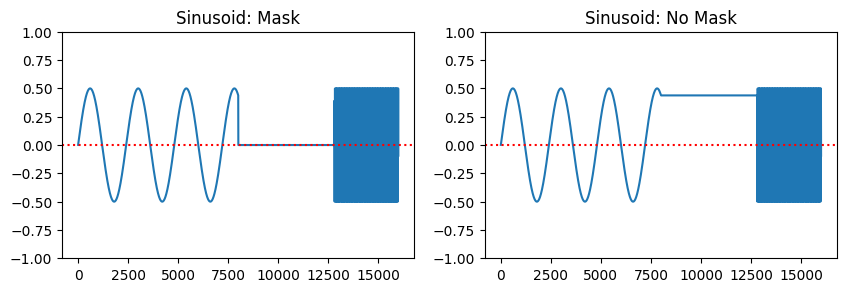

In [4]:
wav_sin_mask = wav_generator(
        torch.sin,
        f0, 
        amp,
        initial_phase,
        sr, 
        gain=0.5,
        is_masking=True)
wav_sin_no_mask = wav_generator(
        torch.sin,
        f0, 
        amp,
        initial_phase,
        sr, 
        gain=0.5,
        is_masking=False)

# figure: mask
plt.figure(figsize=(10, 3), dpi=100)
plt.subplot(1, 2, 1)
plt.plot(wav_sin_mask)
plt.axhline(y=0, c='r', linestyle=':')
plt.title('Sinusoid: Mask')
plt.ylim([-1,1])

# figure: no mask
plt.subplot(1, 2, 2)
plt.plot(wav_sin_no_mask)
plt.axhline(y=0, c='r', linestyle=':')
plt.title('Sinusoid: No Mask')
plt.ylim([-1,1])

In [5]:
def sawtooth_oscillator_original(phase):
    """Sawtooth waveform generator.
    
    Args:
        phase :: (B, T, Partial) - phase at each time point, non-FM sinusoids become sawtooths
    """
    # wrapped phase [0, 2pi]
    phase = phase % (2 * np.pi)
    # [0, 2pi] -> [-1, 1]
    return (phase / np.pi) - 1

def sawtooth_oscillator_reversed(phase):
    """Sawtooth waveform generator."""
    # wrapped phase [0, 2pi], reversed
    phase = 2 * np.pi - phase % (2 * np.pi)
    # [0, 2pi] -> [-1, 1]
    return (phase / np.pi) - 1

(-1.0, 1.0)

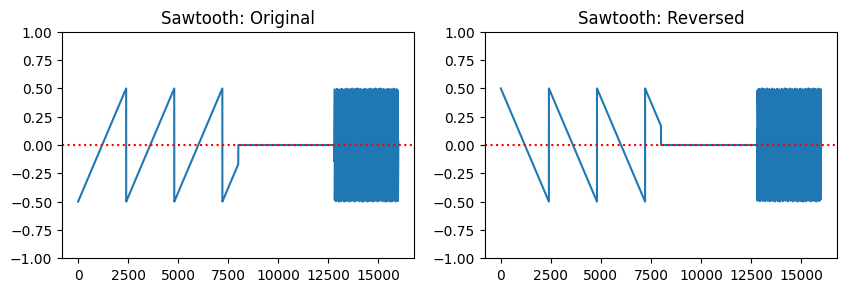

In [6]:
wav_sawtooth_original = wav_generator(
        sawtooth_oscillator_original,
        f0, 
        amp,
        initial_phase,
        sr, 
        gain=0.5,
        is_masking=True)
wav_sawtooth_reversed = wav_generator(
        sawtooth_oscillator_reversed,
        f0, 
        amp,
        initial_phase,
        sr, 
        gain=0.5,
        is_masking=True)


# figure: original
plt.figure(figsize=(10, 3), dpi=100)
plt.subplot(1, 2, 1)
plt.plot(wav_sawtooth_original)
plt.axhline(y=0, c='r', linestyle=':')
plt.title('Sawtooth: Original')
plt.ylim([-1,1])

# figure: reversed
plt.subplot(1, 2, 2)
plt.plot(wav_sawtooth_reversed)
plt.axhline(y=0, c='r', linestyle=':')
plt.title('Sawtooth: Reversed')
plt.ylim([-1,1])

## B. Anti-Aliasing

In [7]:
sr = 44100

# f0 :: (B, T, Partial) - fo contour [Hz]
# constant 1250 Hz
f0 = torch.ones(1, sr, 1).float() * 1250

# amplitude :: (B, T, Partial) - amplitude contour
# constant amplitude
amp = torch.ones(1, sr, 1).float()

# initial phase: (B, T, Partial) - initial phase (Time-invariant)
# zero initial phase
initial_phase = torch.zeros(1, 1, 1).float()

In [8]:
def get_spectrum(wav, fs, nfft=4096):
    S = librosa.stft(wav, n_fft=nfft, hop_length=nfft//2) # half-overlap, full-window STFT
    D = librosa.amplitude_to_db(np.abs(S), ref=np.max) # log-amplitude linear-frequency spectrogram
    
    spectrum = np.mean(D, axis=1) # log-amplitude linear-frequency (averaged) spectrum
    freqs = np.arange(0, 1 + 4096 / 2) * fs / nfft
    return freqs, spectrum


# 1250 Hz sawtooth
wav_sawtooth_original = wav_generator(
        sawtooth_oscillator_reversed,
        f0, 
        amp,
        initial_phase,
        sr, 
        gain=1,
        is_masking=True)

freqs, spectrum = get_spectrum(wav_sawtooth_original, sr)

Text(0.5, 1.0, 'Sawtooth Waveform')

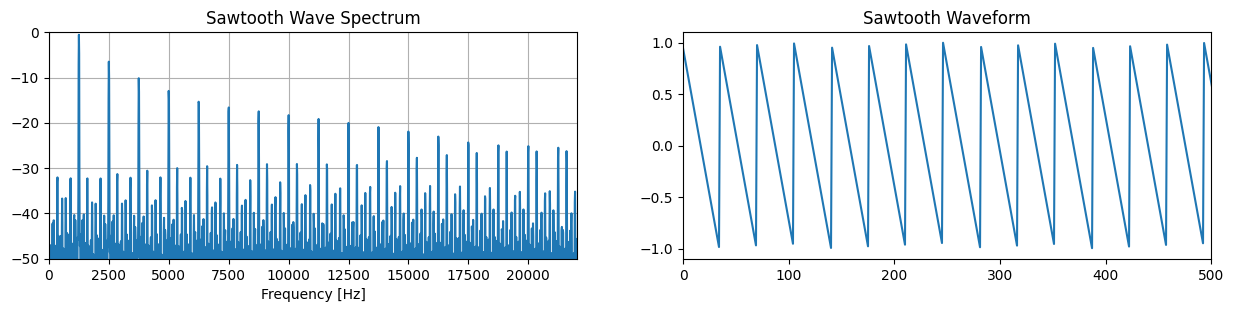

In [9]:
plt.figure(figsize=(15, 3), dpi=100)
plt.subplot(1, 2, 1)
plt.plot(freqs, spectrum)
plt.xlabel('Frequency [Hz]')
plt.ylim(-50, 0)
plt.xlim(0, sr/2)
plt.grid()
plt.title('Sawtooth Wave Spectrum')

plt.subplot(1, 2, 2)
plt.plot(wav_sawtooth_original)
plt.xlim(0, 500)
plt.title('Sawtooth Waveform')

In [10]:
def remove_above_nyquist(amplitudes, pitch, sampling_rate):
    """Remove partials above nyquist frequency.

    Args:
        amplitudes    :: (B, T, Partial) - Partial's amplitudes
        pitch         :: (B, T, Partial) - f0 contour [Hz]
        sampling_rate :: int             - Sampling rate (not nyquist frequency)
    Returns:
        amplitudes    :: (B, T, Partial) - Masked amplitude
    """
    n_harm = amplitudes.shape[-1]
    # Partial's frequency: k*fo [hz]
    pitches = pitch * torch.arange(1, n_harm + 1).to(pitch)
    # zero-mask above nyqust frequency
    aa = (pitches < sampling_rate / 2).float() + 1e-7
    return amplitudes * aa


def harmonic_synthesizer(
        oscillator,                  # :: Callable        - generator function (e.g. `torch.sin`)
        f0,                          # :: (B, T, Partial) - fo contour [Hz]
        amp,                         # :: (B, T, Partial) - Amplitude contour
        initial_phase,               # :: (B, 1, Partial) - initial phase, time-invariant
        sr,                          # :: int             - Sampling rate
        gain=1,                      # :: float           - Global gain
        is_masking=True,             # :: boolean         - Whether to zero-mask when f0 is zero
        is_remove_above_nyquist=True # :: boolean         - Whether to remove partials above nyquist frequency
    ):
    
    n_harmonics = amp.shape[-1]
    print('[H]  n_harmonics:',  n_harmonics)
    
    # phase :: (B, 1, Partial) + (B, T, Partial) -> (B, T, Partial) - 2pi*f0 [rad/s] / sr [sample/s] -> phase progression per step [rad/sample] -> cumsum
    # Under current usage, it is :: (B, T, Partial=1)
    phase = initial_phase + torch.cumsum(2 * np.pi * f0 / sr, axis=1)
    # f=fo partial -> f=k*fo partials :: (B, T, Partial=1) * (Partial,) -> (B, T, Partial)
    phases = phase * torch.arange(1, n_harmonics + 1).to(phase)

    # anti-aliasing
    if is_remove_above_nyquist:
        amp = remove_above_nyquist(amp, f0, sr)

    # generate signal :: (B, T, Partial) * (B, T, Partial) * (1,) -> (B, T, Partial) -> (B, T, 1)
    signal = (oscillator(phases) * amp * gain).sum(-1, keepdim=True)
            
    # mask - zero-mask when f0 is 0 (if False, stop phase progression at any amplitude)
    if is_masking:
        mask = (f0 > 0)
        signal *= mask

    # (B, T, 1) -> (B, T)
    signal = signal.squeeze(-1)    
    
    # (B=1, T) -> (T,)
    return signal.squeeze().numpy()


    # generate signal :: (B, T, Partial) * (B, T, Partial) * (1) -> (B, T, Partial)
    signal = oscillator(phase) * amp * gain
    
    # (B=1, T, Partial=1) -> (T,)


In [11]:
n_harmomnics = 100
# inverse-scale amplitude :: (Partial,) * (B=1, T=sr, Partial=1) -> (B, T, Partial)
amp_sawtooth = 1. / torch.arange(1, n_harmomnics + 1).float() * torch.ones(1, sr, 1)
print(amp_sawtooth.shape, amp.shape)

torch.Size([1, 44100, 100]) torch.Size([1, 44100, 1])


In [12]:
wav_sawtooth_approximated = harmonic_synthesizer(
        torch.sin,
        f0, 
        amp_sawtooth, 
        initial_phase, 
        sr, 
        gain=0.566, 
        is_masking=True,
        is_remove_above_nyquist=True)

[H]  n_harmonics: 100


Text(0.5, 1.0, ' Approximated Sawtooth Waveform')

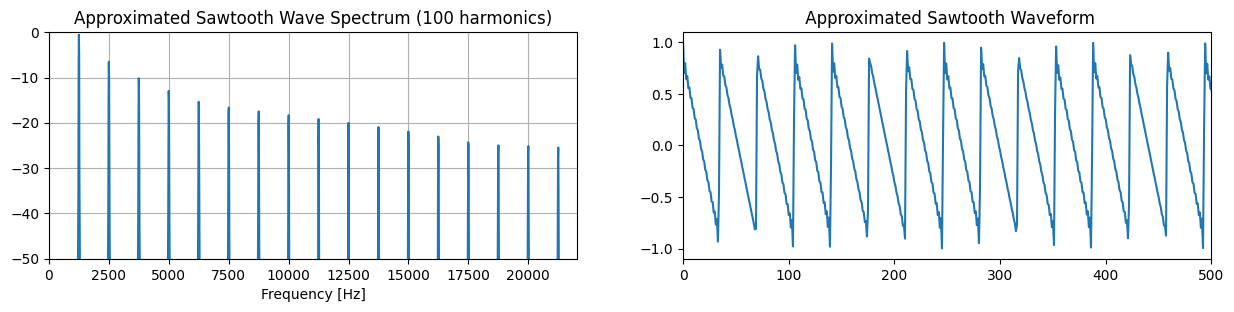

In [13]:
freqs, spectrum_approximated = get_spectrum(wav_sawtooth_approximated, sr)

plt.figure(figsize=(15, 3), dpi=100)
plt.subplot(1, 2, 1)
plt.plot(freqs, spectrum_approximated)
plt.xlabel('Frequency [Hz]')
plt.ylim(-50, 0)
plt.xlim(0, sr/2)
plt.grid()
plt.title(f'Approximated Sawtooth Wave Spectrum ({n_harmomnics} harmonics)')

plt.subplot(1, 2, 2)
plt.plot(wav_sawtooth_approximated)
plt.xlim(0, 500)
plt.title(' Approximated Sawtooth Waveform')

## C. Comparison

In [14]:
plt.figure(figsize=(15, 8), dpi=100)
plt.subplot(2, 2, 1)
plt.plot(wav_sawtooth_original)
plt.xlim(0, 500)
plt.title('Sawtooth Waveform')

plt.subplot(2, 2, 2)
plt.plot(wav_sawtooth_approximated)
plt.xlim(0, 500)
plt.title(' Approximated Sawtooth Waveform')

plt.subplot(2, 2, 3)
plt.plot(freqs, spectrum)
plt.xlabel('Frequency [Hz]')
plt.ylim(-50, 0)
plt.xlim(0, sr/2)
plt.grid()
plt.title(f'Sawtooth Wave Spectrum')

plt.subplot(2, 2, 4)
plt.plot(freqs, spectrum_approximated)
plt.xlabel('Frequency [Hz]')
plt.ylim(-50, 0)
plt.xlim(0, sr/2)
plt.grid()
plt.title(f'Approximated Sawtooth Wave Spectrum ({n_harmomnics} harmonics)')

plt.tight_layout()

In [15]:
ipd.Audio(wav_sawtooth_original, rate=sr, normalize=False)

In [16]:
ipd.Audio(wav_sawtooth_approximated, rate=sr, normalize=False)